In [1]:
import sys, os
print("Kernel Python:", sys.executable)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
print("PyTorch:", torch.__version__)

from tqdm import tqdm
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

Kernel Python: /zhome/c9/0/203261/miniconda3/envs/esm_gpu/bin/python
PyTorch: 2.5.1
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [2]:
import torch
print(torch.version.cuda)   # shows the CUDA version PyTorch was built against
print(torch.backends.cudnn.version())  # cuDNN version
print(torch.cuda.is_available())

12.1
90100
True


In [3]:
# Load metaanalayis data
interaction_df = pd.read_csv("../data/meta_analysis/source_data.csv")
interaction_df = interaction_df[(interaction_df["A_seq"].notna())& (interaction_df["B_seq"].notna())].reset_index(drop=True)
interaction_df = interaction_df[interaction_df["target_chains"] == "[\"B\"]"]
interaction_df = interaction_df[interaction_df["B_seq"].notna()].reset_index(drop=True)
cols_remain = ["binder_id", "target_id", "binder_chain", "target_chains", "binder", "A_seq", "B_seq"]
interaction_df = interaction_df[cols_remain]
# interaction_df = interaction_df.drop(columns=["binder_chain", "target_chains"])

interaction_df

,binder_id,target_id,binder_chain,target_chains,binder,A_seq,B_seq
0,EHEE_rd4_0110_min_rise1_21_000000015_0001,VirB8,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...
1,Grafting_Motif0040_ems_3hM_3083_0001_0002,FGFR2,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...
2,Grafting_Motif0042_ems_3hM_148_0001,FGFR2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...
3,Grafting_Motif0042_ems_3hM_1661_0001,FGFR2,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...
4,Grafting_Motif0042_ems_3hM_257_0001,FGFR2,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...
...,...,...,...,...,...,...,...
3527,il2ra_site1_2b5i_sap_19_mot_HHH_b2_06055_af2_0...,IL2Ra,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...
3528,il2ra_site1_2b5i_sap_20_mot_HHH_b1_01934_af2_0...,IL2Ra,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...
3529,il2ra_site1_2b5i_sap_23_mot_88fc943612ced423dc...,IL2Ra,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...
3530,il2ra_site1_2b5i_sap_25_mot_HHH_b2_01943_00000...,IL2Ra,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...


In [4]:
# No NaN target_id rows
print(f"{len(interaction_df[interaction_df.target_id.isna() == True])} entries with 'target_id' nan")
interaction_df[interaction_df.target_id.isna() == True]

x = interaction_df["target_id"].unique()
print(f"{len(x)} different targets, which are: {x}")

x = interaction_df[interaction_df["target_id"] == "EGFR"]["B_seq"].unique()
print(f"Target 'EGFR' has {len(x)} unique sequences.")

0 entries with 'target_id' nan
13 different targets, which are: ['VirB8' 'FGFR2' 'IL7Ra' 'InsulinR' 'EGFR' 'SARS_CoV2_RBD' 'Pdl1' 'TrkA'
 'IL10Ra' 'LTK' 'Mdm2' 'sntx' 'IL2Ra']
Target 'EGFR' has 3 unique sequences.


In [5]:
print(f"Tagets and number of diff sequences for each:")
for i in interaction_df["target_id"].unique():
    x = interaction_df[interaction_df["target_id"] == i]["B_seq"].unique()
    print(i, len(x))

Tagets and number of diff sequences for each:
VirB8 1
FGFR2 1
IL7Ra 1
InsulinR 1
EGFR 3
SARS_CoV2_RBD 1
Pdl1 1
TrkA 1
IL10Ra 1
LTK 1
Mdm2 1
sntx 2
IL2Ra 1


In [10]:
dfu = interaction_df.drop_duplicates(["target_id", "B_seq"])
dfu[dfu.target_id == "EGFR"].B_seq.tolist()
targets_Dict, target_tracking = {}, {target:int(2) for target in dfu.target_id.unique()}
target_tracking

{'VirB8': 2,
 'FGFR2': 2,
 'IL7Ra': 2,
 'InsulinR': 2,
 'EGFR': 2,
 'SARS_CoV2_RBD': 2,
 'Pdl1': 2,
 'TrkA': 2,
 'IL10Ra': 2,
 'LTK': 2,
 'Mdm2': 2,
 'sntx': 2,
 'IL2Ra': 2}

In [11]:
for idx, target_id in enumerate(dfu.target_id):
    if target_id not in targets_Dict.keys():
        targets_Dict[target_id] = dfu.iloc[idx]["B_seq"]
        print(target_id)
    else:
        target_id_new = f"{target_id}_{target_tracking[target_id]}"
        targets_Dict[target_id_new] = dfu.iloc[idx]["B_seq"]
        count = target_tracking[target_id]
        target_tracking[target_id] = count + 1
        print(target_id_new)

VirB8
FGFR2
IL7Ra
InsulinR
EGFR
SARS_CoV2_RBD
Pdl1
EGFR_2
TrkA
IL10Ra
LTK
Mdm2
EGFR_3
sntx
sntx_2
IL2Ra


In [12]:
interaction_df['target_id_mod'] = interaction_df['B_seq'].map({b:a for a, b in targets_Dict.items()})
interaction_df['B_seq'].map({b:a for a, b in targets_Dict.items()})
print(targets_Dict.keys())
print(f"Entries wheere 'target_id_mod' is NA: {len(interaction_df[interaction_df.target_id_mod.isna() == True])}")

dict_keys(['VirB8', 'FGFR2', 'IL7Ra', 'InsulinR', 'EGFR', 'SARS_CoV2_RBD', 'Pdl1', 'EGFR_2', 'TrkA', 'IL10Ra', 'LTK', 'Mdm2', 'EGFR_3', 'sntx', 'sntx_2', 'IL2Ra'])
Entries wheere 'target_id_mod' is NA: 0


In [13]:
interaction_df[interaction_df.target_id_mod == "EGFR_3"]

,binder_id,target_id,binder_chain,target_chains,binder,A_seq,B_seq,target_id_mod
1130,nside_mot_359448c81ec7171dd466f2d64631b9c5_000...,EGFR,A,"[""B""]",True,DDESLKLLLILVQIQLALERGEISNDQAKELAKRVEEKARKLGDEQ...,VCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYD...,EGFR_3
1516,nside_mot_4a0b58da0a66d934d1bcaa80596e03bc_000...,EGFR,A,"[""B""]",True,DHWEEVFRWALELLQEATEQNDPTKAKKILEEAHKLLRRELSEEEA...,VCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYD...,EGFR_3
2268,nside_mot_33a3a00fc629d06a96f91cefd1c5e1ea_000...,EGFR,A,"[""B""]",True,PLEEVKKVVEEALKDDPELVRAVKTIIEAVKKGENDPIFLELLLRL...,VCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYD...,EGFR_3
2634,nside_mot_4baece34555bc5def11fd3c4c5db93f5_000...,EGFR,A,"[""B""]",True,DEAAEEVLRYLKKLGDPELAELIERLLERVRKKKDPDLERTLEIIA...,VCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYD...,EGFR_3


In [14]:
cnt = interaction_df.groupby('target_id_mod').cumcount() + 1
interaction_df['target_binder_ID'] = interaction_df['target_id_mod'].astype(str) + '_' + cnt.astype(str)
interaction_df

,binder_id,target_id,binder_chain,target_chains,binder,A_seq,B_seq,target_id_mod,target_binder_ID
0,EHEE_rd4_0110_min_rise1_21_000000015_0001,VirB8,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1
1,Grafting_Motif0040_ems_3hM_3083_0001_0002,FGFR2,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1
2,Grafting_Motif0042_ems_3hM_148_0001,FGFR2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2
3,Grafting_Motif0042_ems_3hM_1661_0001,FGFR2,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3
4,Grafting_Motif0042_ems_3hM_257_0001,FGFR2,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4
...,...,...,...,...,...,...,...,...,...
3527,il2ra_site1_2b5i_sap_19_mot_HHH_b2_06055_af2_0...,IL2Ra,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62
3528,il2ra_site1_2b5i_sap_20_mot_HHH_b1_01934_af2_0...,IL2Ra,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63
3529,il2ra_site1_2b5i_sap_23_mot_88fc943612ced423dc...,IL2Ra,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64
3530,il2ra_site1_2b5i_sap_25_mot_HHH_b2_01943_00000...,IL2Ra,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65


In [16]:
interaction_df.binder.value_counts()

binder
False    3141
True      391
Name: count, dtype: int64

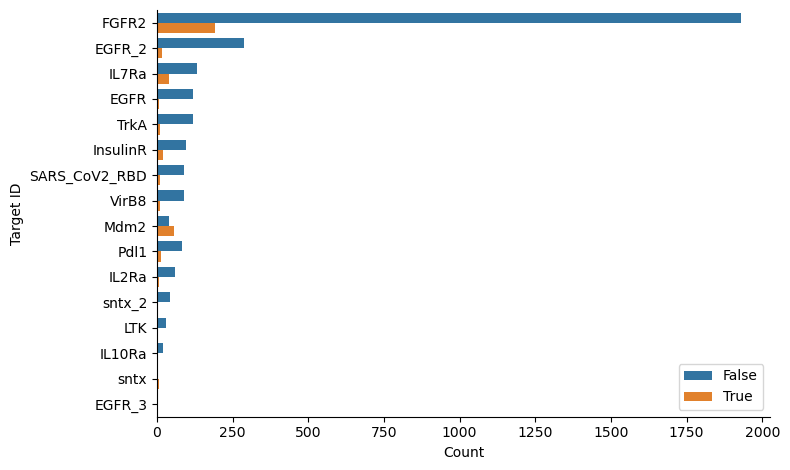

In [32]:
interaction_df.target_id_mod.value_counts()

order = interaction_df['target_id_mod'].value_counts().index

plt.figure(figsize=(8, 0.3 * len(order)))
ax = sns.countplot(
    data=interaction_df,
    y='target_id_mod',
    order=order,
    hue = "binder"
)
ax.set_xlabel('Count')
ax.set_ylabel('Target ID')
ax.legend(loc='lower right')  
sns.despine()
plt.tight_layout()
plt.show()

In [10]:
binders_Dict = {}
for idx, binder_id in enumerate(interaction_df.target_binder_ID):
    if binder_id not in binders_Dict.keys():
        binders_Dict[binder_id] = interaction_df.iloc[idx]["A_seq"]
    else:
        print("Something is off..")
        print(binder_id, interaction_df.iloc[idx]["A_seq"])
binders_Dict

{'VirB8_1': 'LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK',
 'FGFR2_1': 'SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEAKKLVRSLQEYLESILS',
 'FGFR2_2': 'DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRAVRVAMKIVTLVTELM',
 'FGFR2_3': 'DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTESLKKIVEKAETIARRALS',
 'FGFR2_4': 'PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSDEEVKKVVDEIKKYLDSVE',
 'FGFR2_5': 'DDKEHLTKVAREAAKELNDPRAEEAVKIWEHNIDRFSHAAQLAQSVGVKEEYVRMNLRFLVRV',
 'FGFR2_6': 'DLEELIEELARKLNDPELEELLRRLAEQVKKTGDPRLEFMVMNLVIAAKKDPERVKRLARALLKR',
 'FGFR2_7': 'DDAKKAESLLNRLIFYLVKLNTEEADKLAAQAMELINKAQNTDPSERSEILKEAVKIVKSLAG',
 'FGFR2_8': 'DPTAEKWAESARKQAEEARKKNDEKKLRDLMYEALRHAVEAQDPRRTHIFQRALWALMEIAS',
 'FGFR2_9': 'DESEKVRKYVETLVEEAHRKQNPELYRQAAEYALRVVREALKKNDEKRLRAAQQLLFYIVEWA',
 'FGFR2_10': 'PEELEEAIRILEELDPRLREELEKLEELLKKDPHQVYYLLMHLAMRLNDPEVLRLLNRWYFEQVR',
 'FGFR2_11': 'SEEMLQRILFRLTELGNPAASHALRLLIQAFQGEISPEEVLEILKELAKRLGDPELEELLKKAEK',
 'FGFR2_12': 'SVQLVLHAAIVAFMKGDEKAARELQRLAFRLARGEVSEEEADTIAKRILKKLG',

In [ ]:
# Save modified interaction_df
interaction_df.to_csv("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/interaction_df_metaanal.csv")

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# Using CPU for downloading/ loading the model
# device = "cpu"
client = ESMC.from_pretrained("esmc_600m", device=torch.device("cpu")).to("cpu")

# if device == "cuda":
#     client = client.to("cuda").half()              # FP16 fallback
# else:
#     client = client.to("cpu")

# protein = ESMProtein(sequence="AAAAAAA")
# pt = client.encode(protein)                 # usually returns a CPU tensor
# pt = pt.to(next(client.parameters()).device)

# out = client.logits(pt, LogitsConfig(sequence=True, return_embeddings=True))

# Moving model to cuda
client_gpu = client.to("cuda")

In [ ]:
def calculate_ESM_pr_res_embeddings(sequence):
    protein = ESMProtein(sequence=sequence)
    protein_tensor = client_gpu.encode(protein)
    logits_output = client_gpu.logits(
    protein_tensor, LogitsConfig(sequence=True, return_embeddings=True)
    )
    return logits_output.embeddings.detach().cpu().numpy()

# Test run
sequence = "AAAAAAA"
embedding = calculate_ESM_pr_res_embeddings(sequence)
embedding.shape

In [ ]:
# where to save
path_to_output_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings"
os.makedirs(path_to_output_embeddings, exist_ok=True)

# helper: convert torch tensor to numpy
def to_numpy(x):
    try:
        return x.detach().cpu().numpy()
    except AttributeError:
        return np.asarray(x)

# iterate targets
for name, seqs in tqdm(targets_Dict.items(), total=len(targets_Dict), desc="Embedding targets"):
    emb = calculate_ESM_pr_res_embeddings(seqs)
    emb_np = to_numpy(emb)
    out_path = os.path.join(path_to_output_embeddings, f"{name}.npy")
    np.save(out_path, emb_np)
    print(f"Target {name} embedded and saved to {out_path}")

# Count files in the 
# path_to_output_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings"
if len(os.listdir(path_to_output_embeddings)) == len(targets_Dict.keys()):
    print("All targets!")

In [ ]:
# where to save
path_to_output_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings"
os.makedirs(path_to_output_embeddings, exist_ok=True)

# iterate targets
for name, seqs in tqdm(binders_Dict.items(), total=len(binders_Dict), desc="Embedding binders"):
    emb = calculate_ESM_pr_res_embeddings(seqs)
    emb_np = to_numpy(emb)
    out_path = os.path.join(path_to_output_embeddings, f"{name}.npy")
    np.save(out_path, emb_np)
    print(f"Binder {name} embedded and saved to {out_path}")

# Count files in the 
# path_to_output_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings"
if len(os.listdir(path_to_output_embeddings)) == len(binders_Dict.keys()):
    print("All binders!")

In [ ]:
path_to_output_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings"
name = "EGFR_18"
path_to_output_file = os.path.join(path_to_output_embeddings,f"{name}.npy")
random_embedding = np.load(path_to_output_file)
random_embedding.shape

In [ ]:
print(binders_Dict["EGFR_18"])
print(len(binders_Dict["EGFR_18"]))

In [ ]:
interaction_df["A_seq"].apply(lambda x: len(x)).max()
interaction_df["B_seq"].apply(lambda x: len(x)).max()

In [ ]:
path_to_output_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings"
name = "EGFR_18"
path_to_output_file = os.path.join(path_to_output_embeddings,f"{name}.npy")
random_embedding = np.load(path_to_output_file)
random_embedding.shape

In [ ]:
seq = binders_Dict["EGFR_18"]
len(seq)

In [ ]:
os.listdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/")